# The Intro to Bayesian Nets example

## First step: Creating the synthetic applicant data

In [1]:
import pandas as pd
import numpy as np
from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from sklearn.model_selection import train_test_split
from sklearn import metrics
from causalnex.evaluation import classification_report
import matplotlib.pyplot as plt 
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
from causalnex.discretiser import Discretiser
import seaborn as sns

In [65]:
# Create 1000 candidates with normal distributed attributes:
size = 1000
cols = ['colour', 'education', 'work experience', 'drive', 'social commitment', 'hired']
candidate = pd.DataFrame(np.random.randint(0,100,size=(size, len(cols))), columns=cols, index=[*range(size)])

# Introduce skewed binary distributions for hired and colour:
candidate['colour'] = np.random.choice(np.arange(0, 2),size=size, p=[0.7, 0.3])
# Make it more likely to be hired if your colour is 1, with a likelihood of getting hired of 60% if colour==1, and 50% if colour==0:
candidate['hired'] = candidate['colour'].map(lambda x: np.random.choice(np.arange(0, 2), p=[0.4, 0.6]) if x==1 else np.random.choice(np.arange(0, 2), p=[0.5, 0.5]) )

In [2]:
# Create additional column to save wine colour, then merge the data:
wine1['colour']='red'
wine2['colour']='white'
wine = wine1.merge(wine2, how='outer')

In [3]:
hungry = 'hungry'
lunchtime = 'lunchtime'
cooking = 'cooking'

In [4]:
# calculate cpd p(c|h)
# coditional probability table of cooking given hungry
# reality check: each column should add up to 1
cpd2 = pd.pivot_table(abc[[hungry,cooking]],index=hungry, columns=cooking, aggfunc=np.size); 
cpd2 = (cpd2/cpd2.sum()); cpd2

cooking,False,True
hungry,,
False,0.5,0.473684
True,0.5,0.526316


In [5]:
# cpd p(h)
cpd3 = pd.DataFrame(abc.hungry.value_counts(), columns=[hungry])
cpd3 = cpd3/cpd3.sum(); cpd3

,hungry
True,0.515464
False,0.484536


In [6]:
# cpd p(lt|c,h)
cpd1 = pd.pivot_table(abc,index=lunchtime, columns=[cooking,hungry], aggfunc=np.size)
cpd1 = cpd1/cpd1.sum(); cpd1

cooking   False           True       
hungry    False True      False True 
lunchtime                            
False      0.55   0.6  0.666667   0.6
True       0.45   0.4  0.333333   0.4

In [7]:
# Create the structure models, which will contain the graphs:
sm = StructureModel()
sm2 = StructureModel()

In [8]:
# example of a cyclical graph:
sm.add_edges_from([
    ('hungry', 'cooking'),
    ('cooking', 'hungry'),
    ('cooking', 'lunch time'),
    ('hungry', 'lunch time'),
    ('lunch time', 'cooking'),
    ('lunch time', 'hungry')
])

# example of a directed acyclical graph
sm2.add_edges_from([
    ('hungry', 'cooking'),
    ('cooking', 'lunch time'),
    ('hungry', 'lunch time')
])

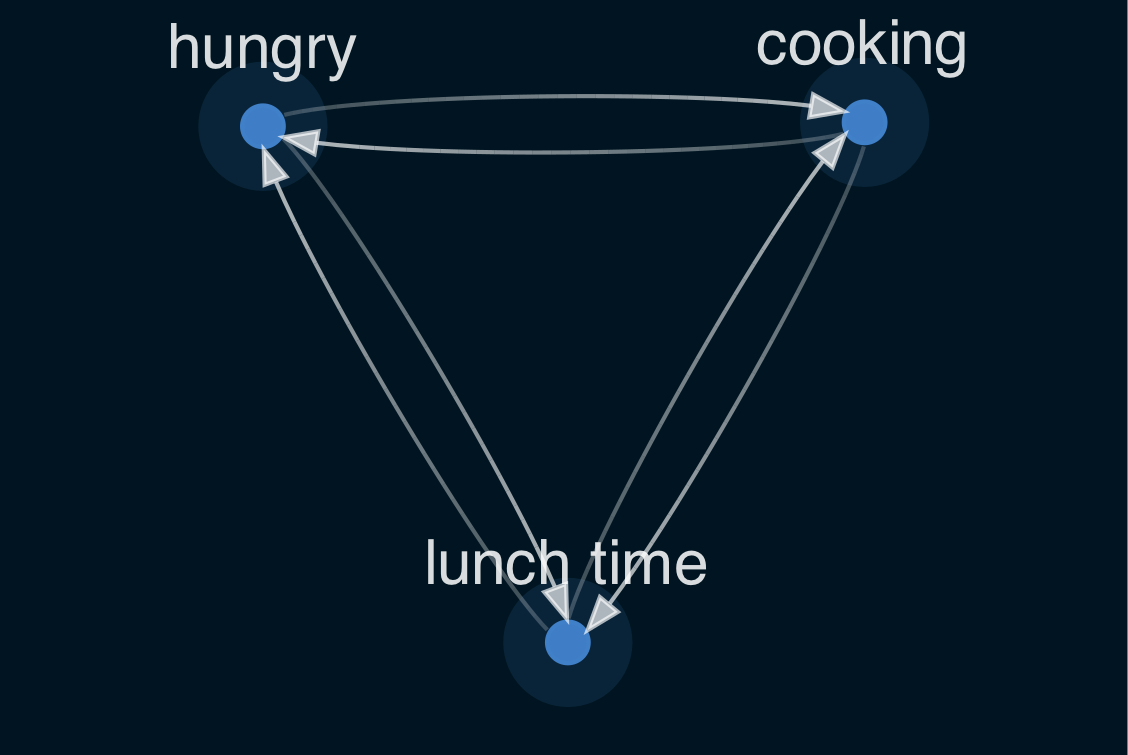

In [9]:
viz = plot_structure(
    sm)
filename = "./plot1.png"
viz.draw(filename)
Image(filename)

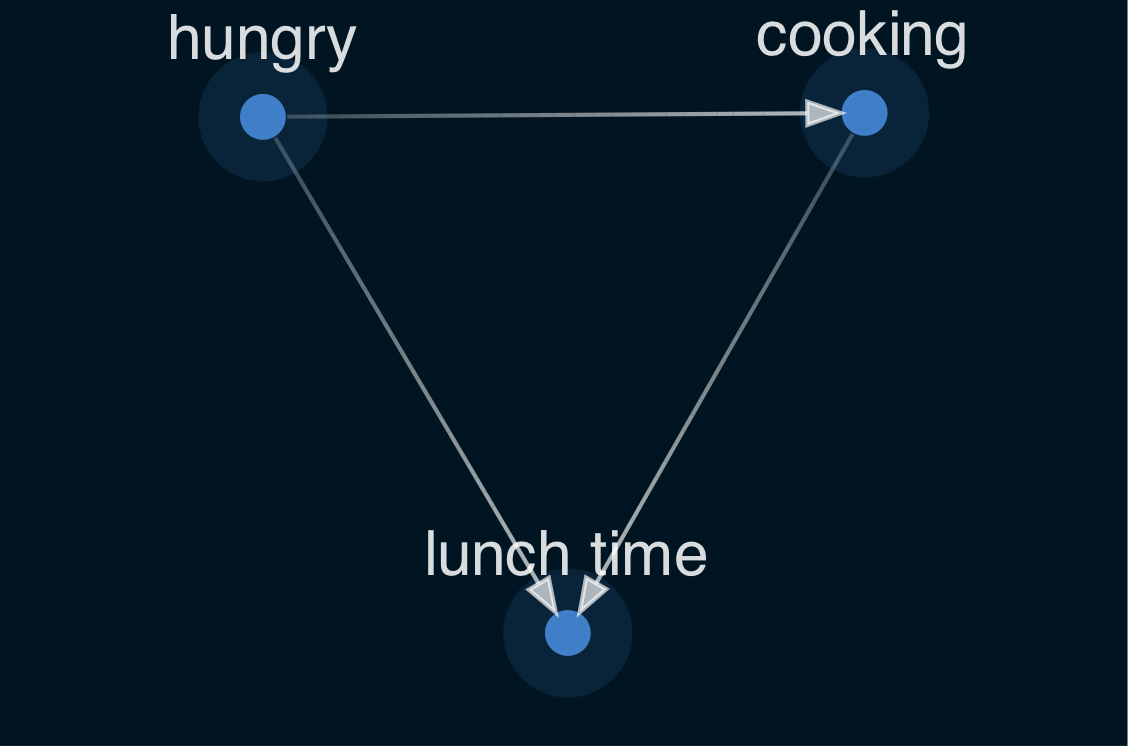

In [10]:
viz = plot_structure(
    sm2)
filename = "./plot2.png"
viz.draw(filename)
Image(filename)

In [11]:
# map the 'True' and 'False' observations to 1 and 0:
maps = {True: 1, False: 0}
abc2 = abc.copy()
for _ in abc2.columns:
    abc2[_] = abc2[_].map(maps)
abc2.head()

,hungry,lunchtime,cooking
0,1,0,1
1,1,1,0
2,0,1,0
3,0,0,1
4,1,1,0


In [12]:
# probability for p(lt|h,c)\*p(c|h)\*p(h) with h=True, c=False, lt=False
p_c_lt_h = cpd1.iloc[0,0]*cpd2.iloc[0,1]*cpd3.iloc[0,0]
print(f"Probability for p(h=True, c=False, lt=False) = {p_c_lt_h*100:.2f}%.")

Probability for p(h=True, c=False, lt=False) = 13.43%.


# And the Wine Dataset:

In [13]:
# map wine colour to integers:
wine['colour'] = wine['colour'].map({'red': 0, 'white': 1})

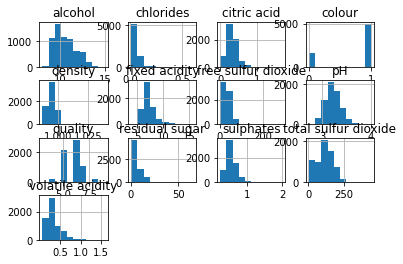

In [14]:
# check histograms for problems:
_ = wine.hist()

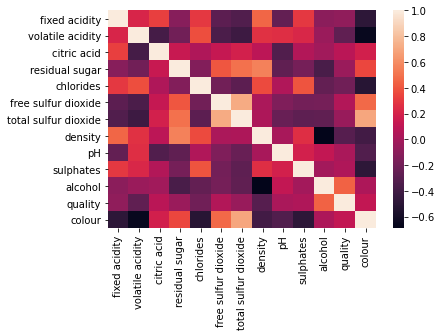

In [15]:
# some further very light EDA (exploratory data analysis):
cor = wine.corr()

# plot the heatmap:
sns.heatmap(cor,
            xticklabels=cor.columns,
            yticklabels=cor.columns)

# not surprised about the alcohol/quality link, but the lack of influence of residual sugar and the others _is_ surprising to me

In [16]:
wine.columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'colour']

In [17]:
# Create a graph, and infer nodes and edges from pandas file:
sm5 = StructureModel()
sm5 = from_pandas(wine, w_threshold=0.99)

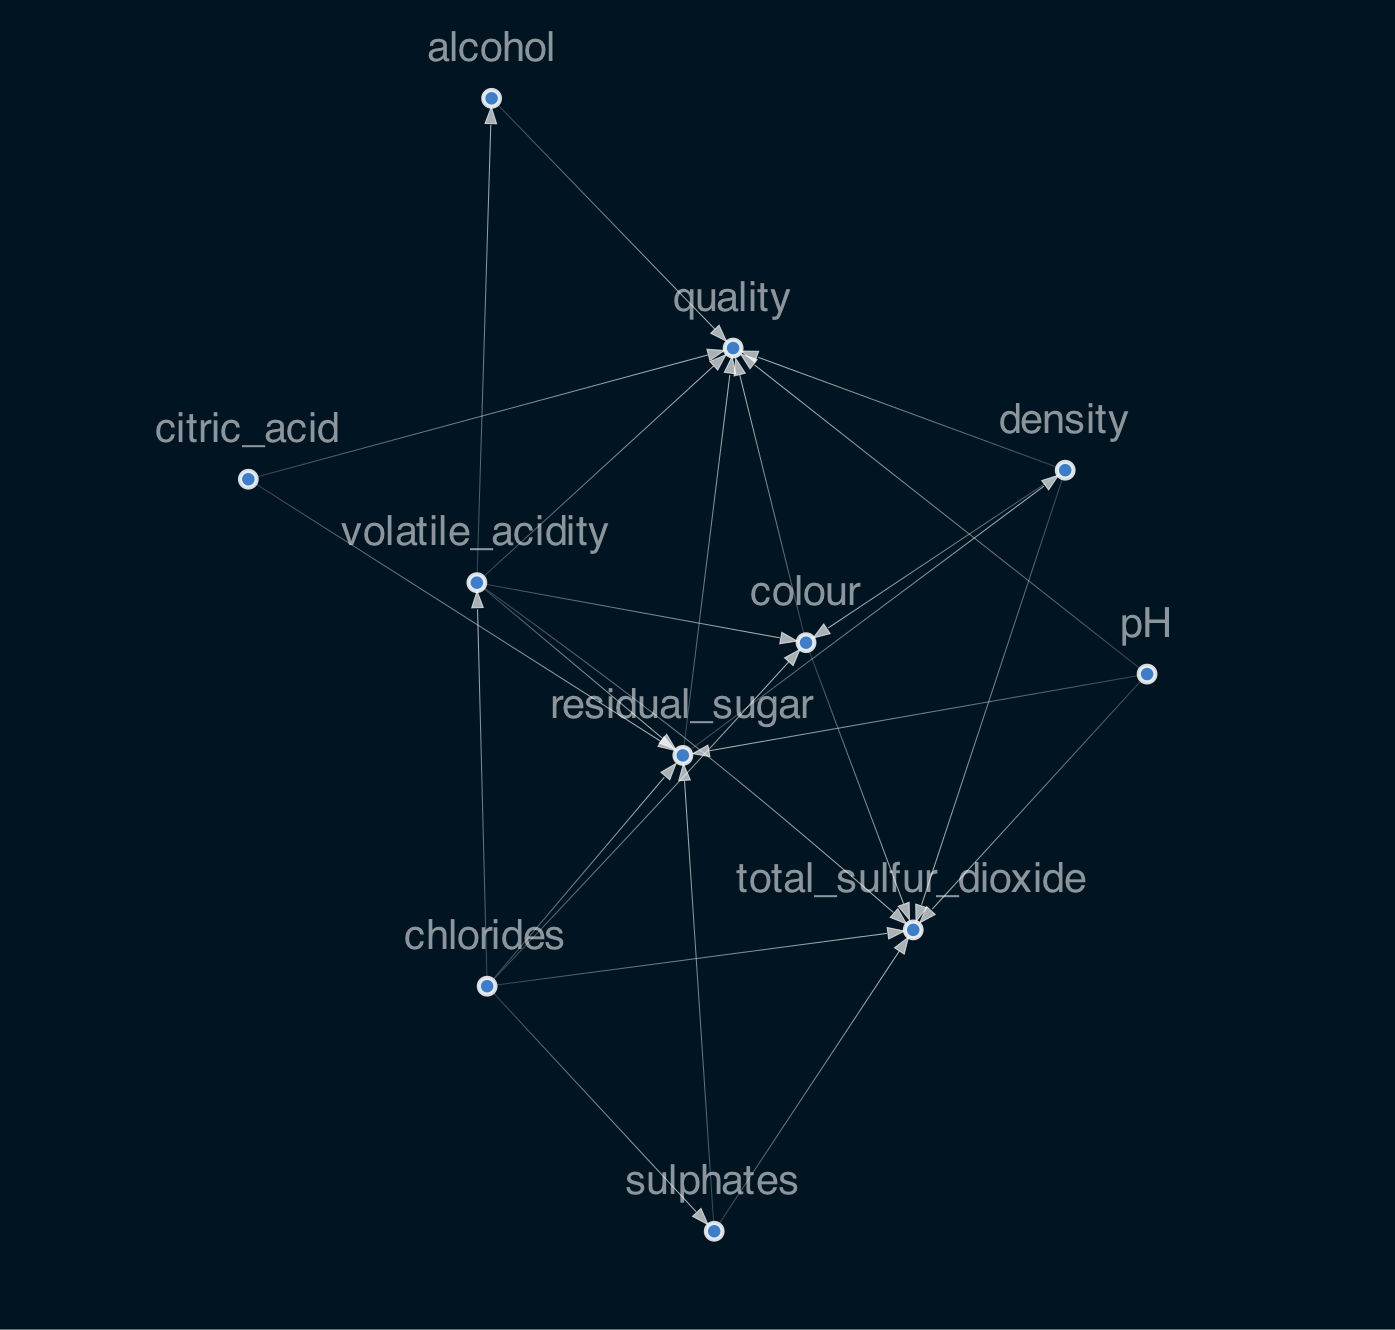

In [18]:
# remove some unnecessary nodes and purge wrong edges:
sm5.remove_node('fixed_acidity')
sm5.remove_node('free_sulfur_dioxide')
sm5.remove_edge("quality", "total_sulfur_dioxide")
sm5.remove_edge("residual_sugar","total_sulfur_dioxide")
sm5.remove_edge("citric_acid","total_sulfur_dioxide")
sm5.remove_edge("alcohol","total_sulfur_dioxide")
sm5.remove_edge("chlorides","alcohol")
sm5.remove_edge("sulphates","density")
sm5.remove_edge('density','residual_sugar')
sm5.remove_edge('colour', 'residual_sugar')
sm5.add_edge('residual_sugar','density')
sm5.remove_edge('density', 'alcohol') 
sm5.remove_edge('alcohol', 'residual_sugar')
sm5.remove_edge('density','pH')
sm5.add_edge("colour",'quality')
sm5.add_edge("residual_sugar",'quality')
sm5.add_edge("citric_acid","quality")
sm5.add_edge('alcohol','quality')
viz = plot_structure(
    sm5,
    graph_attributes={"scale": "1.3"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

In [19]:
# There is a continuous range of data for most variables. As we are not interested in the differences between e.g. pH=3.74 and pH=3.73, we split the variables and discretise them into four levels: very low (0), low(1), high(2), and very high(3):

wine["citric_acid"] = Discretiser(method="fixed",
                          numeric_split_points=[.25,.31,.39]).transform(wine["citric_acid"].values)
wine["volatile_acidity"] = Discretiser(method="fixed",
                          numeric_split_points=[.23,.29,.4]).transform(wine["volatile_acidity"].values)

wine["density"] = Discretiser(method="fixed",
                          numeric_split_points=[0.992340,0.994890,0.996990]).transform(wine["density"].values)

wine["fixed_acidity"] = Discretiser(method="fixed",
                          numeric_split_points=[6,7,7.7]).transform(wine["fixed_acidity"].values)

wine["total_sulfur_dioxide"] = Discretiser(method="fixed",
                          numeric_split_points=[77,118,156]).transform(wine["total_sulfur_dioxide"].values)
wine["free_sulfur_dioxide"] = Discretiser(method="fixed",
                          numeric_split_points=[17,29,41]).transform(wine["free_sulfur_dioxide"].values)

wine["residual_sugar"] = Discretiser(method="fixed",
                          numeric_split_points=[1.8,3,8.1]).transform(wine["residual_sugar"].values)
wine["chlorides"] = Discretiser(method="fixed",
                          numeric_split_points=[.038,.047,.065]).transform(wine["chlorides"].values)
wine["pH"] = Discretiser(method="fixed",
                          numeric_split_points=[3.11,3.21,3.32]).transform(wine["pH"].values)
wine["sulphates"] = Discretiser(method="fixed",
                          numeric_split_points=[.43,.51,.6]).transform(wine["sulphates"].values)   
wine["alcohol"] = Discretiser(method="fixed",
                          numeric_split_points=[9.5,10.3,11.3]).transform(wine["alcohol"].values)              

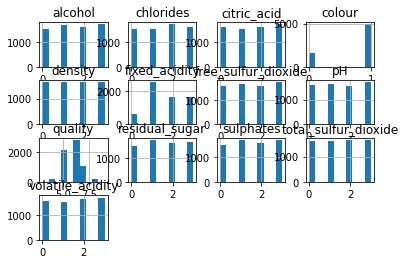

In [20]:
# check the discretisation - are all levels well populated:
a = wine.hist()

In [21]:
## map integers back to legible labels:

# label_map = {0: "v low", 1: "low", 2: "high", 3: "v high"}
# cols = ['volatile_acidity','citric_acid','density','fixed_acidity','total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar','chlorides','pH','sulphates','alcohol']

# for _ in cols:
#     wine[_] = wine[_].map(label_map)

In [22]:
# train/test split the data:
train_w, test_w = train_test_split(wine, train_size=0.85, test_size=0.15, random_state=42)

bn = BayesianNetwork(sm5)

# Ensure that all data is seen, as some of the data may only be in the test set:
bn = bn.fit_node_states(wine)

In [23]:
# obtain conditional probabilities from the train data:
bn = bn.fit_cpds(train_w)

In [24]:
# conditional probabilities for quality:
bn.cpds['quality']

alcohol                  0                                                    \
citric_acid              0                                                     
colour                   0                                                     
density                  0                                                     
pH                       0                                                     
residual_sugar           0                                       1             
volatile_acidity         0         1         2         3         0         1   
quality                                                                        
3                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
4                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
5                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
6                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
7                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
8                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
9                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   

alcohol                                                   ...         3  \
citric_acid                                               ...         3   
colour                                                    ...         1   
density                                                   ...         3   
pH                                                        ...         3   
residual_sugar                               2            ...         1   
volatile_acidity         2         3         0         1  ...         2   
quality                                                   ...             
3                 0.142857  0.142857  0.142857  0.142857  ...  0.142857   
4                 0.142857  0.142857  0.142857  0.142857  ...  0.142857   
5                 0.142857  0.142857  0.142857  0.142857  ...  0.142857   
6                 0.142857  0.142857  0.142857  0.142857  ...  0.142857   
7                 0.142857  0.142857  0.142857  0.142857  ...  0.142857   
8                 0.142857  0.142857  0.142857  0.142857  ...  0.142857   
9                 0.142857  0.142857  0.142857  0.142857  ...  0.142857   

alcohol                                                                       \
citric_acid                                                                    
colour                                                                         
density                                                                        
pH                                                                             
residual_sugar                     2                                       3   
volatile_acidity         3         0         1         2         3         0   
quality                                                                        
3                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
4                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
5                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
6                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
7                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
8                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
9                 0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   

alcohol                                    
citric_acid                                
colour                                     
density                                    
pH                                         
residual_sugar                             
volatile_acidity         1         2    3  
quality                                    
3                 0.142857  0.142857  0.0  
4                 0.142857  0.142857  0.0  
5                 0.142857  0.14

In [25]:
# print(f'"qualit{test_w.loc[3103,'quality']}"')
test_w.loc[3103,'quality']


5

In [26]:
# example prediction:
prediction = bn.predict_probability(test_w.iloc[0:1,:],'quality')
pred = (prediction.loc[3103,prediction.idxmax(axis=1)].index[0]).lstrip('quality'+"_")
truth = test_w.loc[3103,'quality']
print(f'The predicted quality is "{pred}", the true quality value is "{truth}".','\n\n')
print("And a predictions outputs probabilities looking like this:")
prediction

The predicted quality is "5", the true quality value is "5". 


And a predictions outputs probabilities looking like this:


,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
3103,0.0,0.0,0.6,0.4,0.0,0.0,0.0


In [35]:
# To do some quality measurements, lets calculate reciever operator curve (ROC) and area under curve (AUC):

# prepare the truth: 
truth = pd.get_dummies(test_w['quality'])
for var in bn.node_states['quality']:
        if var not in truth.columns:
            truth[var] = 0

predictions = bn.predict_probability(test_w,'quality')
predictions.columns = predictions.columns.str.replace('quality_','')
fpr, tpr, _= metrics.roc_curve(truth.values.ravel(), predictions.values.ravel()) 
roc = list(zip(fpr, tpr))
auc = metrics.auc(fpr, tpr)

print(f'Area under the curve (AUC): {auc*100:.1f}%')
# The area under curve (AUC) is a good measure of model quality, in the case of a balanced dataset. A perfect model would have a AUC=1, a model deciding randomly AUC=1/2, and if AUC<1/2 you probably have a sign error somewhere, or the model is really, terribly bad.

Area under the curve (AUC): 94.2%


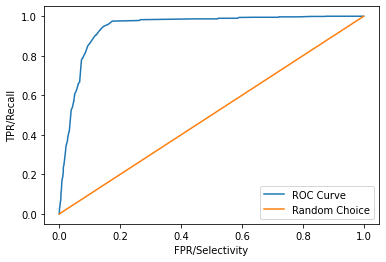

In [36]:
# plot the reciever operator curve (ROC), from which the AUC is determined. The AUC corresponds to the FPR*TPR maximum on the ROC curve inflection point.
a = pd.DataFrame(roc, columns=['FPR','TPR'])
_ = plt.plot(a['FPR'],a['TPR'], label='ROC Curve')
_ = plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],label='Random Choice')
_ = plt.legend(loc='lower right')
# _ = plt.grid()
_ = plt.xlabel('FPR/Selectivity')
_ = plt.ylabel('TPR/Recall')

This graph shows the quality of the model, where in an ideal case the ble line would always very close the ideal curve fulfilling TPR*FPR=1.
The 84.4% area under the curve (AUC) are a good result, which with some work can surely be improved upon, especially considering the low values for [FPR](https://en.wikipedia.org/wiki/False_Positive_Rate).

In [30]:
# re-fit to include all data in dataset for node modification calcs:

bn = bn.fit_cpds(wine, method="BayesianEstimator", bayes_prior="K2")
ie = InferenceEngine(bn)

# marginals = ie.query()
# marginals["quality"]
# marginals_df = pd.DataFrame(columns=['probability'])
# for _ in marginals["quality"].keys():
#     marginals_df.loc[_,'probability'] = marginals["quality"][_]

In [31]:
wine.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'colour'],
      dtype='object')

In [32]:
def effec_of_changes(change_node, result_node, new_distrib, ie_):
    """
    Visualise the effects of changes in one node

    Input:
        change_node: (str) node the change is applied to
        result_node: (str) node we are interested in
        new_distrib: (dict) new distribution of values with keys according
                            to result node
        ie_: (causal nex inference engine object) 

    Returns:
        plot: Bar plot of the resulting changes
    """
    marg_list = [ie_.query({change_node: _})['quality'] for _ in range(4)]
    before = ie_.query()[result_node]
    ie_.do_intervention(change_node,new_distrib)
    after = ie.query()[result_node]
    ie_.reset_do(change_node)
    changes = pd.DataFrame([before,after],
                           index=[f'old {change_node}',
                           f'new {change_node}'])
    changes.loc['dif'] = (changes.loc[f'new {change_node}'] - 
                          changes.loc[f'old {change_node}']
                          )*100/changes.loc[f'old {change_node}']

    a = changes.transpose()['dif'].plot.bar()
    plt.ylabel('Change (%)')
    plt.xlabel('Quality')
    return a

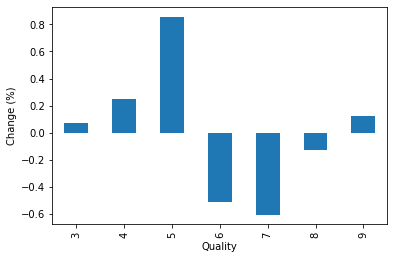

In [33]:
# shift of citric_acid to higher levels in the wine:
_ = effec_of_changes('citric_acid', 'quality', {0: 0.2, 1: 0.1, 2: 0.1, 3: 0.6}, ie)

It looks like a bad idea to increase the citric acid content in wine, as it makes it likelier for the wine to be of lower quality. Albeit the absolute and relative effect are both quite small.

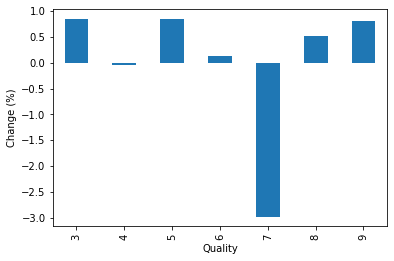

In [37]:
_ = effec_of_changes('residual_sugar', 'quality', {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, ie)

An interesting mixed bag, which does increase both very good, and very bad wines, but overall the intervention shows no clear trend. I am not surprised the residual sugar has this effect, as most very, _very_ cheap wines tend to mask the lack of body with sugar. On the contrary, some very good and more rare wines, like ice wines have a high residual sugar content combined with a higher quality.

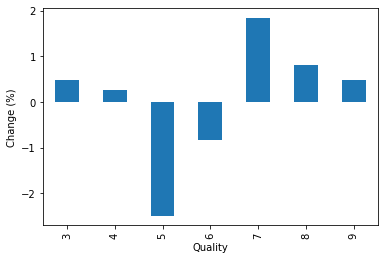

In [38]:
_ = effec_of_changes('pH', 'quality', {0: 0.0, 1: 0.2, 2: 0.1, 3: 0.7}, ie)

This looks like the best intervention, as the effect of changing the pH value to a larger value (making the wine less acidic), makes it more likely for wines to be of higher quality.